## Import statements

We need to import some libraries to communicate with S3.

In [6]:
%%capture
!pip install boto3
!pip install pandas
!pip install matplotlib

In [7]:
import boto3
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

## User input

Provide the bucket name where the data is streamed into and the topic to which you published the messages. This corresponds to the location of the prefix in the S3 bucket where the data is saved. You can always check in the AWS Console in the S3 service, what the folder structure is. In my case it is `s3://bucket-name//topic/wilson`.

In [8]:
TOPIC = 'topic/wilson/'

The code below attempts to download the data from the S3 bucket provided and store it locally in the notebook instance. You can navigate back to the Jupyter environment (the one that opened after you clicked 'Open Jupyter') and see the folder structure represented from the S3 bucket.

If the data was downloaded successfully, we read the message contents into a dataframe and plot it. You can re-execute the code to update the plot. Note that every time the code is executed, the whole content in the S3 prefix ("folder") is downloaded.

In [9]:
s3 = boto3.resource('s3')

BUCKET_NAME = 'hamsterwheel_iot_bucket'


def download_s3_folder(bucket_name: str, s3_folder: str, local_dir: str = None) -> None:
    """
    Download the contents of a prefix in S3.
    
    Args:
        bucket_name: The name of the s3 bucket.
        s3_folder: The prefix of data in the s3 bucket to download.
        local_dir: a relative or absolute directory path in the local file system
    
    Returns:
        Nothing, downloads files in the S3 bucket into `local_dir`.
    """
    bucket = s3.Bucket(bucket_name)
    
    for obj in bucket.objects.filter(Prefix=s3_folder):
        target = obj.key if local_dir is None \
            else os.path.join(local_dir, os.path.relpath(obj.key, s3_folder))
        if not os.path.exists(os.path.dirname(target)):
            os.makedirs(os.path.dirname(target))
        if obj.key[-1] == '/':
            continue
        bucket.download_file(obj.key, target)

download_s3_folder(
    bucket_name=BUCKET_NAME,
    s3_folder=TOPIC
)

The code below will load the files that you downloaded form S3 locally to this machine and collect the JSON messages in a pandas dataframe.

In [10]:
# Read the files in the directory
path = TOPIC
files = os.listdir(path)

# Read json content into pandas series
dfs = [pd.read_json(f'./{path}/{f}', typ='series', dtype={"Timestamp": str, "Message": str}) for f in files]

# Concatenate series and turn into pandas dataframe
df = pd.concat(dfs, axis=1).T


# Processing
def convert_to_timestamp(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """Converts column `col` of `df` to timestamp inferring the datetime format.
    """
    df[col] = pd.to_datetime(df[col], infer_datetime_format=True)
    return df


def convert_to_int(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """Converts column `col` of `df` to int.
    """
    df[col] = df[col].astype(int)
    return df


df = (
    df
    .pipe(func=convert_to_timestamp, col='Timestamp')
    .pipe(func=convert_to_int, col='Message')
    .sort_values(by=['Timestamp'])
    .set_index('Timestamp', drop=True)
)

df.tail()

,Message
Timestamp,
2023-03-27 12:32:47,1
2023-03-27 12:32:48,1
2023-03-27 12:32:49,0
2023-03-27 12:32:50,1
2023-03-27 12:32:51,1


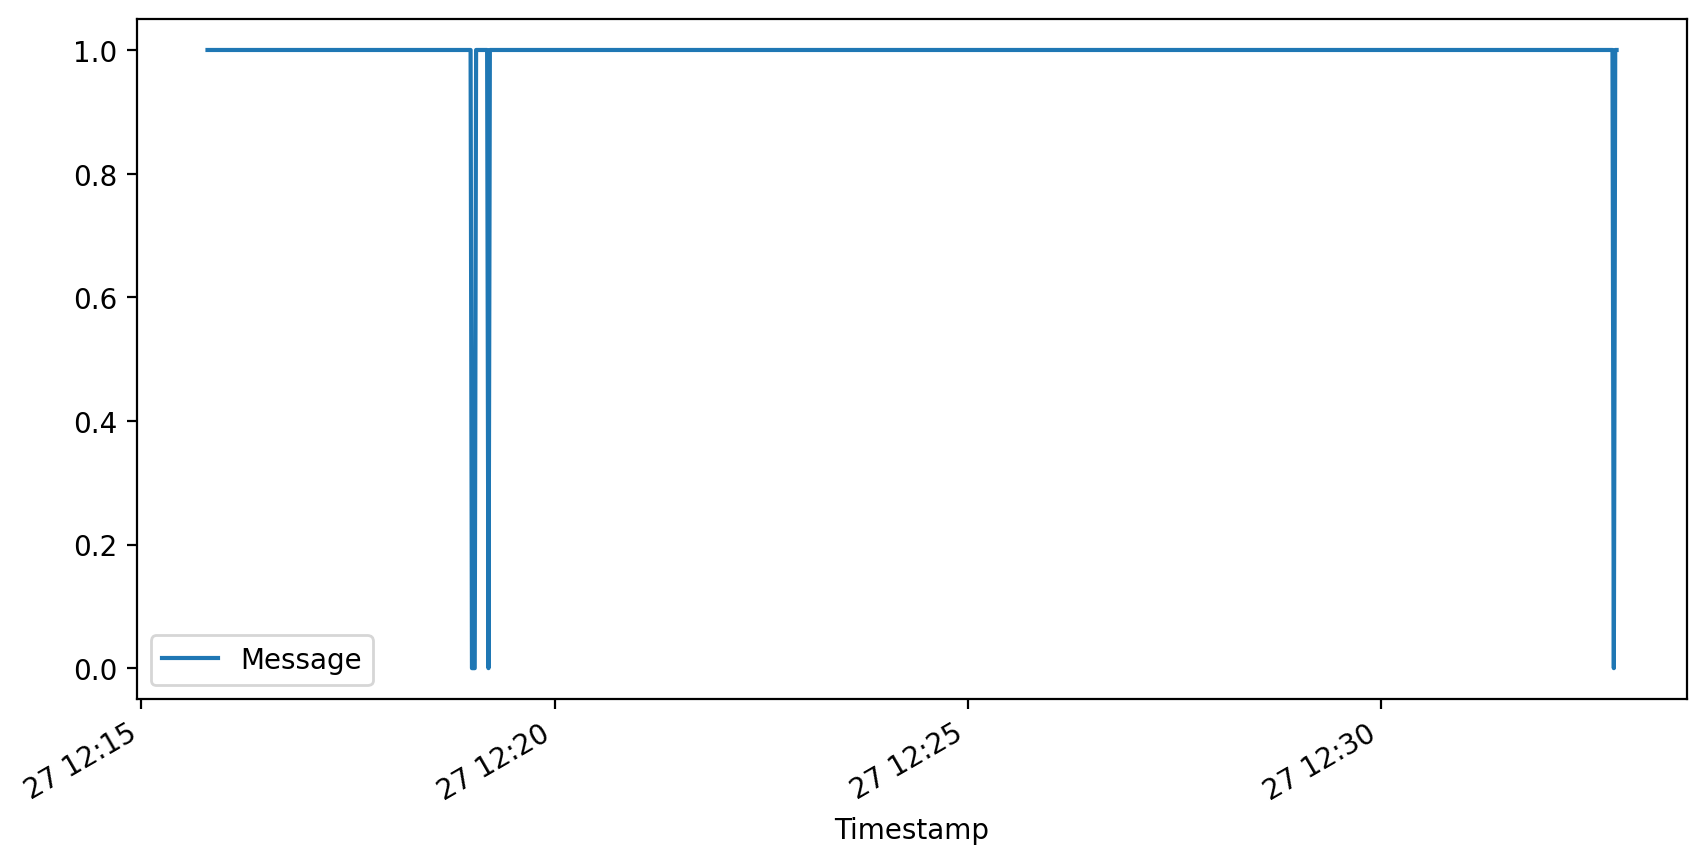

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(kind='line', ax=ax);